In [109]:
%pylab inline
import numpy as np
import scipy as sc
import pandas as pd

import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("talk")
#rc('axes', labelsize=20, titlesize=20)

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import scipy.stats as ss

from ABC_algorithm import ABC 

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Normal example

In [99]:
######
# set up for the normal ABC example
######

prior_mean = -4.0
prior_sd = 3
likelihood_sd = 4

def NormalPriorSampler(n):
    return np.random.normal(loc=prior_mean, scale=prior_sd, size=n)

def NormalLiklihoodSimulator(n, param):
    #unknown mean
    return np.random.normal(loc=param, scale=likelihood_sd, size=n)
    
def NormalSummary(data):
    return np.mean(data, axis=0)

data = np.random.normal(loc=0,scale=likelihood_sd,size=100)

post_sd = np.power((1.0/np.power(prior_sd,2) + len(data)/np.power(likelihood_sd,2)),-1/2)
post_mean = (prior_mean/np.power(prior_sd,2) + np.sum(data)/(np.power(likelihood_sd,2)))/(1/np.power(prior_sd,2) + len(data)/np.power(likelihood_sd,2))
print post_mean, "is posterior mean"
print post_sd, "is posterior std dev"

-0.65008575006 is posterior mean
0.163636363636 is posterior std dev


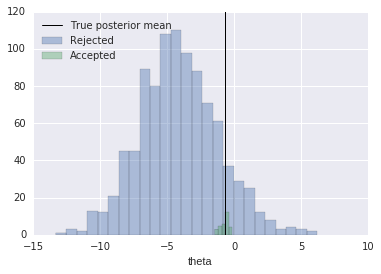

In [100]:
######
# run ABC for the normal example
######

df = ABC(NormalPriorSampler, NormalLiklihoodSimulator, NormalSummary, 0.2, data , 1000)

######
# plot the accepted and rejected params
######

fig, ax = plt.subplots()

accept_legend_map = {1:'Accepted',0:'Rejected'}
for accept,sub_df in df.groupby('accept'):
    sns.distplot(sub_df.theta, ax=ax, kde = False, label=accept_legend_map[accept]) #norm_hist =True,

plt.axvline(x=post_mean, ymin=0, ymax = 120, linewidth=1, color='k', label='True posterior mean')
plt.legend(loc='upper left')
plt.savefig('plots/1d_normal_abc.pdf')

## Evaluate MSE

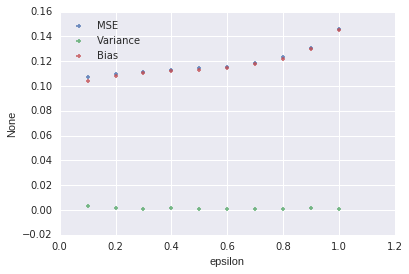

In [110]:
epsilon_count = 10
epsilon = 0
epsilon_increment = 0.1

k = 50
n = 5000

error_epsilon_list = []

for _ in range(epsilon_count):
    epsilon = epsilon + epsilon_increment
    #print "epsilon:{}".format(epsilon)

    abc_post_medians = []
    
    for i in range(k):
        #print "Iteration:{}".format(i)
        df_ei = ABC(NormalPriorSampler, NormalLiklihoodSimulator, NormalSummary, epsilon, data, n)
        abc_post_median = df_ei[df_ei.accept == 1].theta.median()
        abc_post_medians.append(abc_post_median)
        mse += np.power((abc_post_median - post_mean),2)/k # squared diff
    
    var = np.var(abc_post_medians)
    error_epsilon_list.append({'mse':mse, 'epsilon':epsilon, 'variance':var})
    
mse_df = pd.DataFrame(error_epsilon_list)
mse_df.bias = mse_df.mse - mse_df.variance

sns.regplot(x=mse_df.epsilon, y=mse_df.mse, marker="+", fit_reg=False, label='MSE')
sns.regplot(x=mse_df.epsilon, y=mse_df.variance, marker="+", fit_reg=False, label='Variance')
sns.regplot(x=mse_df.epsilon, y=mse_df.bias, marker="+", fit_reg=False, label='Bias')
plt.legend(loc='upper left')
plt.savefig('plots/1d_normal_abc_epsilon_k{}_n{}_.pdf'.format(k,n))